<a href="https://colab.research.google.com/github/cesar-yoab/Yield-Curves/blob/main/APM466.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APM466 Assignment 1: Yield Curves


In [ ]:
# Importing some dependencies
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy import optimize

## Collecting data
For each weekday from Jan 10th, 2022, to January 24, 2022 (inclusive, 2 weeks worth, 10 days), collect all
historical close prices for all Canadian Government Bonds which have a maturity less than 10 years from
January 10, 2022 on the “Frankfurt” Exchange; I.e., all bonds listed via the following two links:
- [Bonds between 0 and 3 years](https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=shortterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19)
- [Bonds between 3 and 10 years](https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=midterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19)

For each bond, we collected the following information: coupon, ISIN, issue date, maturity
date. 

In [ ]:
def get_bond_data(download=False):
    if not download:
        return pd.read_csv("/content/bond_data.csv")
    
    links = [
         "https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=shortterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19",
         "https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=midterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19"
    ]
    col_names = ['Issuer', 'currency', 'Coupon', 'yield', 'moody', 'Maturity', 'bid', 'ask']
    data = {'Name': [], "ISIN": [], "Coupon": [], "IssueDate": [], "Maturity": []}

    for link in links:
        page = requests.get(link)
        if page.status_code != 200:
            print(f"{link} not working")
            continue
        
        soup = BeautifulSoup(page.content, 'html.parser')
        table = soup.find('table', attrs={'class':'table'})
        table_body = table.find('tbody')

        rows = table_body.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            # This is where we find ISIN, price and issue date
            link = row.find_all("a", href=True)[0]['href']

            #cols = [ele.text.strip() for ele in cols]
            cols = [ele for ele in [ele.text.strip() for ele in cols] if ele]
            data_dict = {k:v for k, v in zip(col_names, cols)}
            metadata = get_metadata(f"https://markets.businessinsider.com{link}")

            data['Name'].append(metadata['Name'])
            data['ISIN'].append(metadata['ISIN'])
            data['Coupon'].append(data_dict['Coupon'])
            data['IssueDate'].append(metadata['IssueDate'])
            data['Maturity'].append(metadata['Maturity'])

    return pd.DataFrame(data)

def get_metadata(link):
    page = requests.get(link)
    data = {'ISIN': '', 'IssueDate': '', 'Name': ''}
    if page.status_code != 200:
        print(f"{link} not working")
        return
        
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find('table', attrs={'class':'table table--no-vertical-border'})
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        if len(cols) != 2:
            continue
        col_name, val = cols
        if col_name == 'ISIN':
            data['ISIN'] = val
        elif col_name == 'Issue Date':
            data['IssueDate'] = val
        elif col_name == 'Name':
            data['Name'] = val
        elif col_name == 'Maturity Date':
            data['Maturity'] = val
    
    return data

In [ ]:
# Collect some metadata
bond_data = get_bond_data()

In [ ]:
# Clean data
try:
    bond_data['Coupon'] = bond_data['Coupon'].apply(lambda x: float(x.replace('%', '')))
except Exception as e:
    print(e)
bond_data['Maturity'] = pd.to_datetime(bond_data['Maturity'])
bond_data['IssueDate'] = pd.to_datetime(bond_data['IssueDate'])
bond_data.head()

'float' object has no attribute 'replace'


,Name,ISIN,Coupon,IssueDate,Maturity
0,CDA 2023,CA135087A610,1.50,2012-07-29,2023-05-31
1,CDA 2024 01.06,CA135087B451,2.50,2013-07-01,2024-05-31
2,CDA 2022,CA135087G328,0.50,2016-10-10,2022-02-28
3,CDA 2023,CA135087H490,1.75,2017-10-05,2023-02-28
4,CDA 2024,CA135087J546,2.25,2018-10-04,2024-02-29


In [ ]:
# Read closing prices from CSV file
bond_data_daily = pd.read_csv("/content/bond_data_daily.csv")
bond_data_daily.head()

,CA135087A610,CA135087B451,CA135087G328,CA135087H490,CA135087J546,CA135087K601,CA135087K866,CA135087L286,CA135087L369,CA135087L690,CA135087L773,CA135087L856,CA135087M359,CA135087M508,CA135087M763,CA135087M920,CA135087UM44,CA135087UT96,CA135087ZU15,CA135087D507,CA135087E679,CA135087F825,CA135087H235,CA135087J397,CA135087K528,CA135087K940,CA135087L443,CA135087L518,CA135087L930,CA135087M276,CA135087M847,CA135087N266,CA135087VH40,CA135087VW17,CA135087WL43,CA135087J967
0,100.71,130.02,100.04,100.94,102.31,100.07,100.35,99.80,99.55,97.96,99.31,99.08,98.80,98.55,98.96,99.20,103.39,109.62,100.90,102.91,100.12,97.18,102.39,104.44,99.64,96.66,90.21,95.11,97.66,98.00,98.41,97.40,125.14,133.30,128.79,100.56
1,100.70,102.98,100.03,100.93,102.31,100.06,100.34,99.79,99.54,97.96,99.26,99.07,98.80,98.56,98.95,99.20,103.36,109.59,100.89,102.89,100.17,97.28,102.47,104.59,99.67,96.72,90.36,95.17,97.70,98.18,98.47,97.59,125.17,133.37,128.92,100.63
2,100.67,102.97,100.03,100.91,102.26,100.06,100.34,99.78,99.52,97.93,99.29,99.05,98.78,98.53,98.93,99.16,103.33,109.54,100.88,102.90,100.13,97.32,102.37,104.60,99.61,96.77,90.25,95.12,97.67,98.02,98.40,97.42,125.09,133.30,128.79,100.62
3,100.64,102.93,100.03,100.88,102.22,100.05,100.32,99.77,99.52,97.90,99.28,99.04,98.76,98.48,98.91,99.13,103.25,109.46,100.85,102.87,100.12,97.31,102.39,104.60,99.59,96.77,90.28,95.14,97.69,98.09,98.44,97.50,125.01,133.22,128.78,100.58
4,100.61,102.88,100.02,100.86,102.18,100.04,100.31,99.76,99.50,97.86,99.26,99.01,98.73,98.44,98.87,99.09,103.21,109.42,100.84,102.79,100.01,97.19,102.24,104.38,99.49,96.68,90.05,95.04,97.58,97.81,98.31,97.21,124.91,133.06,128.52,100.52


## Bond Selection
We are asked to construct "0-5 year" yield and spot curves and since the government of Canada issues all of its bonds with a semi-annual coupon,
when bootstrapping we’ll only need 10 bonds to perform this task. 

We will select the bonds that mature with "about" 6 months difference.

In [ ]:
bond_data.sort_values(by="Maturity")

,Name,ISIN,Coupon,IssueDate,Maturity
6,CANADA 19/22,CA135087K601,1.50,2019-11-03,2022-01-31
2,CDA 2022,CA135087G328,0.50,2016-10-10,2022-02-28
7,CANADA 20/22,CA135087K866,1.50,2020-01-26,2022-04-30
17,CDA 2022 01.06,CA135087UM44,9.25,1991-12-14,2022-05-31
19,CDA 2022,CA135087ZU15,2.75,2011-08-01,2022-05-31
8,CANADA 20/22,CA135087L286,0.25,2020-05-03,2022-07-31
9,CANADA 20/22,CA135087L369,0.25,2020-08-16,2022-10-31
11,CANADA 20/23,CA135087L773,0.25,2020-10-25,2023-01-31
3,CDA 2023,CA135087H490,1.75,2017-10-05,2023-02-28
12,CANADA 21/23,CA135087L856,0.25,2021-02-04,2023-04-30


In [ ]:
# The 10 bonds used throught this assignment
selected_bonds_mask = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d'), ["2022-07-31", "2023-01-31", "2023-07-31", 
                  "2024-01-31", "2024-08-31", "2025-02-28", "2025-08-31", 
                  "2026-02-28", "2026-08-31", "2027-02-28"]))

selected_bonds = bond_data[bond_data['Maturity'].isin(selected_bonds_mask)]
selected_bonds = selected_bonds.sort_values(by='Maturity')

## Yield curves
First, calculate each of your 10 selected bonds’ yield (ytm). Then provide a well labeled plot with a 5-year yield curve (ytm curve) corresponding to each day of data superimposed on-top of each other.

Formula for ytm
$$P=\sum_{t=1}^n \frac{C}{(1+r)^{t}} + \frac{F}{(1+r)^n}$$

where we have the variables

- $P$: Price today
- $r$: Interest rate
- $F$: Face value of bond
- $n$: Number of compounding periods till maturity
- $C$: Coupon payment


In [ ]:
class Bond:
    def __init__(self, name, isin, coupon, issue_date, 
                 maturity, price_history, face_value=100,
                 bond_freq=2):
        self._name = name
        self._isin = isin
        self._coupon = coupon
        self._issue_date = issue_date
        self._maturity = maturity
        self._price_history = price_history
        self._face_value = face_value
        self._bond_freq = bond_freq
        self._years_to_maturity = relativedelta(self._maturity, datetime(2022, 1, 2)).years

        self._calculate_periods()

    def _calculate_periods(self):
        periods = 0
        date = datetime(2022, 7, 31)

        while self._maturity >= date:
            periods += 1
            date = date + relativedelta(months=6)
        
        self._periods = periods

    def bond_info(self, i=0):
        print(f"=== {self._isin}===")
        print(f"Coupon: {self._coupon}")
        print(f"Maturity: {self._maturity}")
        print(f"Price at index: {self._price_history[i]}")
        print(f"Years to maturity: {self._years_to_maturity}")

    def ytm(self, index_price, estimate=0.05):
        price = self._price_history[index_price]
        compute_yield = lambda r: self.compute_price(r) - price
        return optimize.newton(compute_yield, estimate)

    def compute_price(self, r):
        coupon_payments = 0
        coupon = self._coupon / self._bond_freq

        for i in range(self._periods):
            coupon_payments += coupon / (1 + r)**(i+1)

        face_value = self._face_value / (1+r)**(self._periods)
        return coupon_payments + face_value

    @classmethod
    def build_from_df(cls, bond_data, bond_history):
        return [
            Bond(
            name=row.Name,
            isin=row.ISIN,
            coupon=row.Coupon,
            issue_date=row.IssueDate,
            maturity=row.Maturity,
            price_history=bond_history[row.ISIN].tolist()) 
            for row in bond_data.itertuples()]

In [ ]:
def data_days():
    """Returns list of data collection dates"""
    date = datetime(2022, 1, 10)
    days = [date]
    while date != datetime(2022, 1, 24):
        date += timedelta(days=1)
        if date.weekday() > 4:
            continue
        days.append(date)

    return days

def calculate_all_ytms(bonds):
    """Returns a dataframe with the calculated yield curves"""
    yields = {'Maturity': [], 'Yield': [], "CollectionDate": []}
    dates = data_days()

    for i, date in enumerate(dates):
        for bond in bonds:
            ytm = 100 * bond.ytm(i)
            yields['Maturity'].append(bond._maturity)
            yields['Yield'].append(ytm)
            yields['CollectionDate'].append(date.strftime("%b-%d"))
    
    return pd.DataFrame(yields)

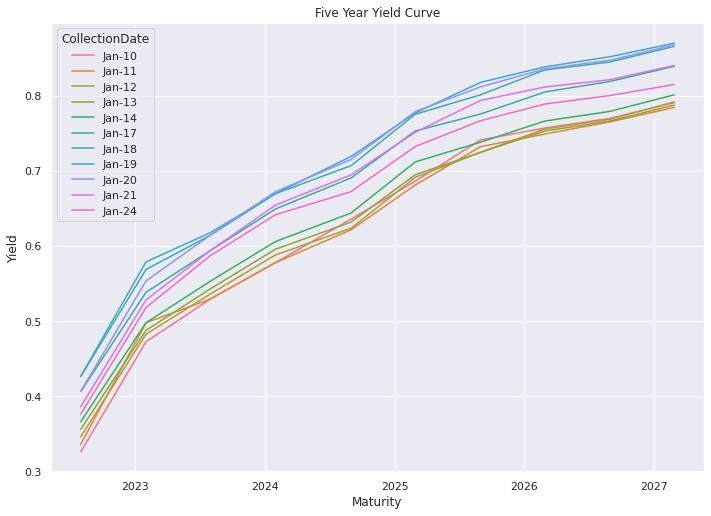

In [ ]:
# Calculate yields and generate plot
bonds = Bond.build_from_df(selected_bonds, bond_data_daily)
yields = calculate_all_ytms(bonds)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt = sns.lineplot(data=yields, x="Maturity", y="Yield", hue="CollectionDate")
plt.set_title("Five Year Yield Curve")
plt.get_figure().savefig("five_year_yield_curve.png")

## Spot Curves
The **bootstrapping** technique is based on the price-yield equation using different rates for each of the 6-month terms, as determined by market prices:
$$P=\sum_{t=1}^n\frac{C}{(1+r_t)^t} + \frac{F}{(1+r_n)^n}$$

The interest rate is 1st calculated for the 6-month bond that has a known market price, which has only a single payment, consisting of the coupon payment and the principal repayment, at its maturity. After the rate is calculated for the 1st period with the 6-month bond, then that rate is used to calculate the rate for the 2nd period of a 1-year bond, and so on, until all the rates for the desired number of terms for which there are market prices available have been determined. This is called the bootstrapping technique, because the prior calculated spot rates are used to calculate later spot rates in successive steps.

In [ ]:
class SpotBond(Bond):
    def __init__(self, name, isin, coupon, issue_date, 
                 maturity, price_history, face_value=100,
                 bond_freq=2):
        super().__init__(name, isin, coupon, issue_date, maturity,
                         price_history, face_value, bond_freq)
        
        self._all_spot_rates = []
        self._spot_rates = []
    
    def compute_all_spot_rates(self):
        for i, price in enumerate(self._price_history):
            try:
                rates = self.compute_spot_rates(price)
                self._all_spot_rates.append(rates)
                self._spot_rates = []
            except Exception as e:
                print(f"Error price: {price} with index {i}")
                print(e)
                continue
        
        return self._all_spot_rates

    def compute_spot_rates(self, price, estimate=0.05):
        for t in range(self._periods):
            if t == 0:
                coupon = self._coupon / self._bond_freq
                rate = (coupon + self._face_value) / price
                self._spot_rates.append(rate - 1)
                continue

            r_t = self._spot_rate_at_period(t+1, price, self._spot_rates[-1])
            self._spot_rates.append(r_t)

        return self._spot_rates

    def _spot_rate_at_period(self, t, price, estimate):
        spot_rate = lambda r_t: self.compute_price(r_t, t) - price
        try:
            return optimize.newton(spot_rate, estimate)
        except Exception as e:
            #print(t)
            return self._spot_rates[-1]

    def compute_price(self, r_t, t):
        coupon = self._coupon / self._bond_freq
        P = 0
        for t, rate in enumerate(self._spot_rates):
            P += coupon / (1+rate)**(t+1)
        
        P += (coupon + self._face_value) / (1+r_t)**t
        return P
    
    @classmethod
    def build_from_df(cls, bond_data, bond_history):
        return [
            SpotBond(
            name=row.Name,
            isin=row.ISIN,
            coupon=row.Coupon,
            issue_date=row.IssueDate,
            maturity=row.Maturity,
            price_history=bond_history[row.ISIN].tolist()) 
            for row in bond_data.itertuples()]
  

In [ ]:
def calculate_all_spot_rates(bonds):
    spots = {'Maturity': [], 'SpotRate': [], "CollectionDate": []}
    dates = data_days()

    for bond in bonds:
        spot_rates = bond.compute_all_spot_rates()
        for i, date in enumerate(dates):
            spot_rate = 100*np.array(spot_rates[i]).mean()
            spots['Maturity'].append(bond._maturity)
            spots['SpotRate'].append(spot_rate)
            spots['CollectionDate'].append(date.strftime("%Y-%m-%d"))

    return pd.DataFrame(spots)

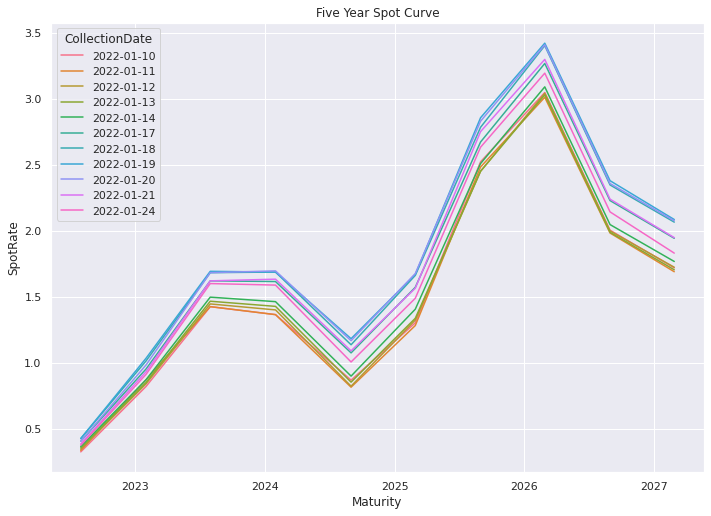

In [ ]:
bonds = SpotBond.build_from_df(selected_bonds, bond_data_daily)
spot_rates = calculate_all_spot_rates(bonds)
plt = sns.lineplot(data=spot_rates, x="Maturity", y="SpotRate", hue="CollectionDate")
plt.set_title("Five Year Spot Curve")
plt.get_figure().savefig("five_year_spot_curve.png")

## Forward Curve
Traditional forward formula is
$$f_{t,1}=\frac{(1+r_{t+1})^{t+1}}{(1+r_t)^t}-1$$

In [ ]:
def get_year_bond(bonds, year):
    for bond in bonds:
        if bond._periods != year*2:
            continue
        
        return bond

def calculate_forward_rates(bonds):
    df = {"Period": [], 
          "ForwardRate": [], 
          "CollectionDate": []}
    dates = data_days()

    for year in range(2, 6):
        bond = get_year_bond(bonds, year)
        all_spot_rates = bond._all_spot_rates

        for i, date in enumerate(dates):
            spot_rates = all_spot_rates[i]
            f = 100*forward_rate(spot_rates, year)
            df['ForwardRate'].append(f)
            df['Period'].append(f'1yr-{year-1}yr')
            df['CollectionDate'].append(date.strftime("%Y-%m-%d"))

    return pd.DataFrame(df)

def forward_rate(spot_rates, year):
    r_1, r_t = spot_rates[0], spot_rates[-1]
    periods = year*2
    f = ((1+r_t)**periods)/(1+r_1)
    return f - 1

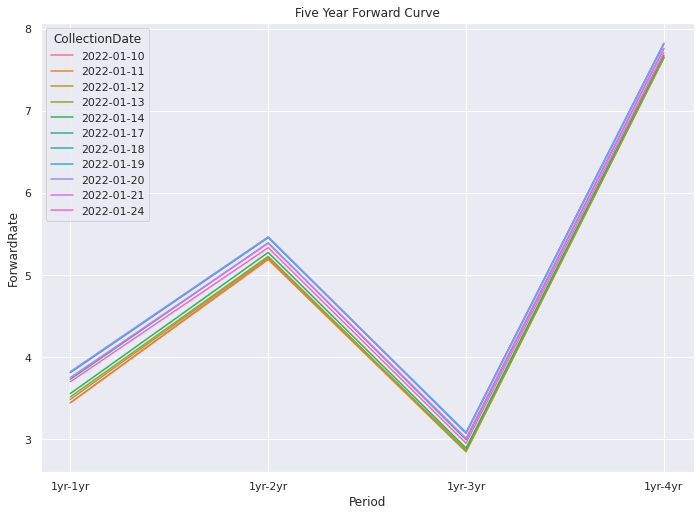

In [ ]:
forward_rates = calculate_forward_rates(bonds)
plt = sns.lineplot(data=forward_rates, x="Period", y="ForwardRate", hue="CollectionDate")
plt.set_title("Five Year Forward Curve")
plt.get_figure().savefig("five_year_forward_curve.png")

## Covariance Matrices of Daily Log-Returns of Yield and Forward Rates

In [ ]:
def spot_cov_matrix(bonds):
    dates = data_days()
    matrix = []
    #final_matrix = [[], [], [], [], []]

    for year in range(1, 6):
        bond = get_year_bond(bonds, year)
        all_spot_rates = bond._all_spot_rates
        rates = []
        for i, date in enumerate(dates):
            spot_rate = 100*np.array(all_spot_rates[i]).mean()
            rates.append(spot_rate)
        matrix.append(rates)
    
    return np_cov_matrix(matrix)

def forward_cov_matrix(bonds):
    matrix = [[], [], [], []]
    dates = data_days()

    for year in range(2, 6):
        bond = get_year_bond(bonds, year)
        all_spot_rates = bond._all_spot_rates

        for i, date in enumerate(dates):
            spot_rates = all_spot_rates[i]
            f = 100*forward_rate(spot_rates, year)
            matrix[year-2].append(f)
    
    return np_cov_matrix(matrix)
    

def np_cov_matrix(matrix):
    final_matrix = []
    for i, row in enumerate(matrix):
        final_matrix.append([])
        for j in range(len(row)-1):
            final_matrix[i].append(np.log(row[j+1]/row[j]))
    
    final_matrix = np.array(final_matrix)
    return np.cov(final_matrix)

In [ ]:
# Spot covariance matrix
spot_cov = spot_cov_matrix(bonds)
spot_cov

array([[0.0025054 , 0.00135354, 0.00176002, 0.00101033, 0.00174877],
       [0.00135354, 0.00147292, 0.00196484, 0.00104086, 0.00181864],
       [0.00176002, 0.00196484, 0.00276001, 0.00146477, 0.00257544],
       [0.00101033, 0.00104086, 0.00146477, 0.00081681, 0.00142064],
       [0.00174877, 0.00181864, 0.00257544, 0.00142064, 0.0024906 ]])

In [ ]:
# Forwad rates covariance matrix
forward_cov = forward_cov_matrix(bonds)
forward_cov

array([[3.49654686e-04, 1.91088785e-04, 3.18278428e-04, 1.00474081e-04],
       [1.91088785e-04, 1.09585568e-04, 1.83194454e-04, 5.81917362e-05],
       [3.18278428e-04, 1.83194454e-04, 3.19921655e-04, 1.00703386e-04],
       [1.00474081e-04, 5.81917362e-05, 1.00703386e-04, 3.19357979e-05]])

In [ ]:
# Spot eigen -vector/-values
spot_eigen = np.linalg.eig(spot_cov)
spot_eigen

(array([8.82361480e-03, 1.08630503e-03, 2.66854863e-05, 3.76884802e-06,
        1.05370078e-04]),
 array([[-0.42899316, -0.90077575, -0.06733823, -0.00570435,  0.00096514],
        [-0.39619076,  0.14831871,  0.52022354,  0.10904721, -0.73383283],
        [-0.54630089,  0.31596972, -0.73531034, -0.1619913 , -0.18653685],
        [-0.29806281,  0.11987972,  0.36847339, -0.80910521,  0.32613423],
        [-0.52125968,  0.22890302,  0.21995248,  0.55424159,  0.56597608]]))

In [ ]:
# Spot eigen -vector/-values
forward_eigen = np.linalg.eig(forward_cov)
forward_eigen

(array([7.92051229e-04, 1.68962471e-05, 2.01660898e-06, 1.33621623e-07]),
 array([[ 0.6560661 ,  0.71434484,  0.23943797,  0.04425143],
        [ 0.36910141, -0.02239136, -0.90902727, -0.19217752],
        [ 0.62775767, -0.66959238,  0.3208093 , -0.23376857],
        [ 0.19814571, -0.20212898, -0.11584595,  0.95208291]]))